# Aufgabe 3c: Verkehrszeichenerkennung
Diese Aufgabe wurde in Anlehnung an Aufgabe 3b erstellt und wurde wieder in Google Colab gelöst. Vor dem Trainieren war aber eine erhöhte Datenvorverarbeitung nötig.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import skimage

## load data
Diese Funktion lädt die Daten aus der Ordnerstruktur und übergibt sie mehreren Variablen.

In [0]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

ROOT_PATH = "/content/drive/My Drive/Colab Notebooks/"
train_data_directory = os.path.join(ROOT_PATH, "TrafficSigns/Training")
test_data_directory = os.path.join(ROOT_PATH, "TrafficSigns/Testing")

train_images, train_labels = load_data(train_data_directory)
test_images, test_labels = load_data(test_data_directory)

In [7]:
type(train_images)

list

In [0]:
train_images, train_labels = np.array(train_images), np.array(train_labels)
test_images, test_labels = np.array(test_images), np.array(test_labels)

In [10]:
train_images.shape, train_labels.shape

((4575,), (4575,))

In [11]:
test_images.shape, test_labels.shape

((2528,), (2528,))

## images und labels
Um mehr Trainingsdaten zu haben, wurden Test und Trainingsdaten kombiniert und später im Verhältnis 80/20 wieder aufgeteilt.

In [0]:
images = np.concatenate((train_images, test_images), axis=0)

In [0]:
labels = np.concatenate((train_labels, test_labels), axis=0)

In [14]:
images.shape

(7103,)

In [15]:
labels.shape

(7103,)

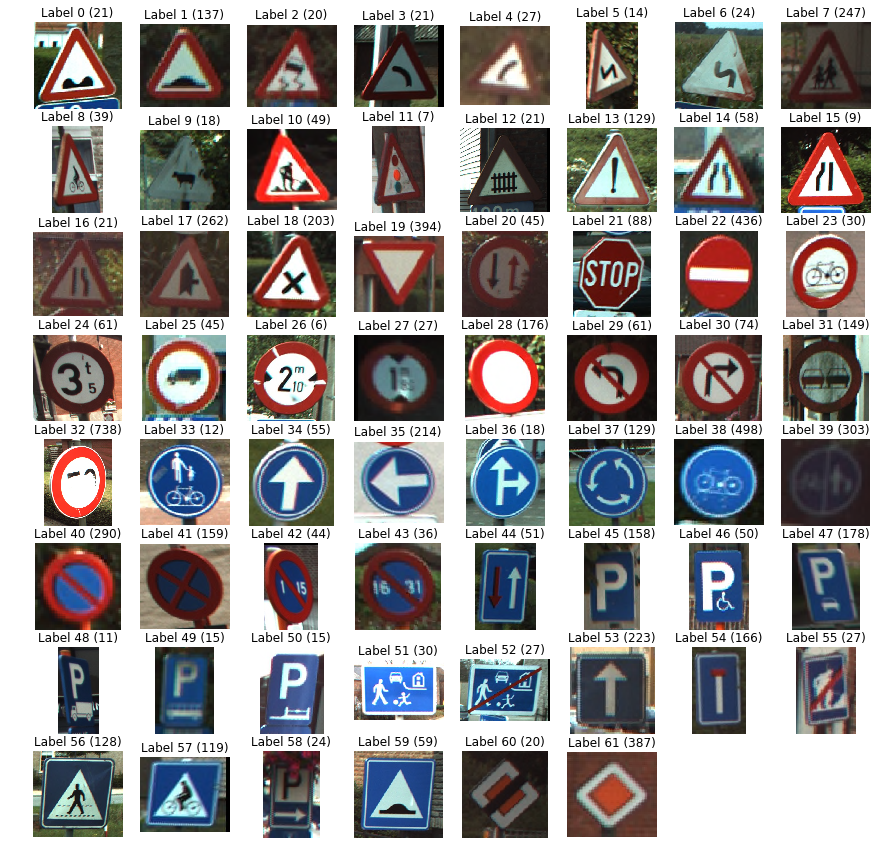

In [19]:
# Get the unique labels 
unique_labels = set(train_labels)

# Initialize the figure
plt.figure(figsize=(15, 15))

# Set a counter
i = 1

# For each unique label,
for label in unique_labels:
    # You pick the first image for each label
    image = images[np.where(labels == label)[0][0]]
    # Define 64 subplots 
    plt.subplot(8, 8, i)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    plt.title("Label {0} ({1})".format(label, np.count_nonzero(labels == label)))
    # Add 1 to the counter
    i += 1
    # And you plot this first image 
    plt.imshow(image)
    
# Show the plot
plt.show()

## Bildgröße
Die Bilder der Verkehrsschilder haben alle eine unterschiedliche Größe. Für das Training werden sie deshalb in 28x28 pixelgroßen Bildern überführt.

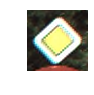

shape: (60, 60, 3), min: 2, max: 255


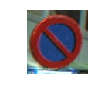

shape: (83, 79, 3), min: 1, max: 255


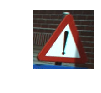

shape: (129, 134, 3), min: 0, max: 255


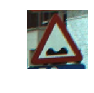

shape: (94, 98, 3), min: 0, max: 255


In [18]:
traffic_signs = [300, 2250, 3650, 7094]

# Fill out the subplots with the random images and add shape, min and max values
for i in range(len(traffic_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images[traffic_signs[i]])
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    print("shape: {0}, min: {1}, max: {2}".format(images[traffic_signs[i]].shape, 
                                                  images[traffic_signs[i]].min(), 
                                                  images[traffic_signs[i]].max()))

## Grau
Um das Training zu beschleunigen kann es hilfreich, sein wenn die Bilder in Graustufen gespeichert werden. Die Farbigen Bilder werden aber auch beibehalten.

In [0]:
from skimage import transform 

# Rescale the images in the `images` array
images = [transform.resize(image, (28, 28)) for image in images]

In [0]:
from skimage.color import rgb2gray

# Convert `images28` to an array
images = np.array(images)

# Convert `images28` to grayscale
images_grey = rgb2gray(images)

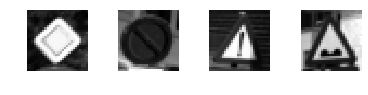

In [23]:
traffic_signs = [300, 2250, 3650, 7094]

for i in range(len(traffic_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images_grey[traffic_signs[i]], cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
# Show the plot
plt.show()

In [24]:
images_grey.shape

(7103, 28, 28)

## Split
Sowohl für graue, als auch für farbige Bilder wird ein Train Test Split durchgeführt.

In [0]:
from sklearn.model_selection import train_test_split

X_train_color, X_test_color, X_train_grey, X_test_grey, y_train, y_test = train_test_split(images, images_grey, labels, test_size=0.2)

In [31]:
X_train_color.shape, X_test_color.shape, X_train_grey.shape, X_test_grey.shape

((5682, 28, 28, 3), (1421, 28, 28, 3), (5682, 28, 28), (1421, 28, 28))

In [0]:
X_train_reshaped_grey = X_train_grey.reshape(5682, 28, 28, 1) / 255
X_test_reshaped_grey = X_test_grey.reshape(1421, 28, 28, 1) / 255

In [0]:
X_train_reshaped_color = X_train_color.reshape(5682, 28, 28, 3) / 255
X_test_reshaped_color = X_test_color.reshape(1421, 28, 28, 3) / 255

In [35]:
X_train_reshaped_grey.shape, X_test_reshaped_grey.shape, y_train.shape, y_test.shape

((5682, 28, 28, 1), (1421, 28, 28, 1), (5682,), (1421,))

In [36]:
X_train_reshaped_color.shape, X_test_reshaped_color.shape, y_train.shape, y_test.shape

((5682, 28, 28, 3), (1421, 28, 28, 3), (5682,), (1421,))

## OneHot
Die Zielvariable wird onehot encoded.

In [37]:
from keras.utils import to_categorical

y_train_coded = to_categorical(y_train)
y_test_coded = to_categorical(y_test)

print(y_train_coded[0])

Using TensorFlow backend.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [38]:
y_train_coded.shape[1]

62

In [0]:
def plot_history(history): 
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(history.history['loss'])
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylim([0, 2])
    ax[0].set_title('Loss over Epochs')
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['Training loss', 'Prediction loss'])

    ax[1].plot(history.history['acc'])
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylim([0, 1])
    ax[1].set_title('Accuracy over Epochs')
    ax[1].plot(history.history['val_acc'])
    ax[1].legend(['Training accuracy', 'Prediction accuracy'])

    fig.suptitle("Model Quality over Epochs")

    plt.show()

# Modelle
Die ersten drei Modelle verwenden die graustufen Bilder, die letzten drei Modelle greifen auf die farbigen Bilder zurück. Modell 1 und 4, 2 und 5, bzw. 3 und 6 sind von der Strukturn ansonsten gleich und werden deshalb nur im ersten Durchlauf erklärt.

## Modell 1
besteht aus 2 Conv Layern. Beim ersten wurde ein padding verwendet damit die Größe der Bilder gleich bleibt. Um die Parameterzahl zu veringern wurde im ersten Layer ein stride von 2 verwendet und in beiden layern ein maxpooling von 2x2 Feldern. Vor dem Output wurde noch ein Flatten Layer eingefügt der die ausladenden Convoluts auf einen 1 dim array abbildet. Es konnte bereits eine Testgenauigkeit von ca. 84% erreicht werden.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

model_1 = Sequential()
model_1.add(Conv2D(5, kernel_size=3, activation='relu', input_shape=(28, 28, 1), padding='same', strides=2, dilation_rate=1))
model_1.add(MaxPool2D(2))
model_1.add(BatchNormalization())

model_1.add(Conv2D(15, kernel_size=3, activation='relu', input_shape=(28, 28, 1), padding='same', strides=1, dilation_rate=1))
model_1.add(MaxPool2D(2))
model_1.add(Flatten())
model_1.add(Dense(62, activation='softmax'))

In [102]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 14, 14, 5)         50        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 5)           0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 7, 7, 5)           20        
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 15)          690       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 3, 3, 15)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 135)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 62)                8432      
Total para

In [0]:
model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [0]:
model_1_training = model_1.fit(
    X_train_reshaped_grey,
    y_train_coded, 
    validation_data=(X_test_reshaped_grey, y_test_coded),
    epochs=25,
    batch_size=16,
    verbose=False
)

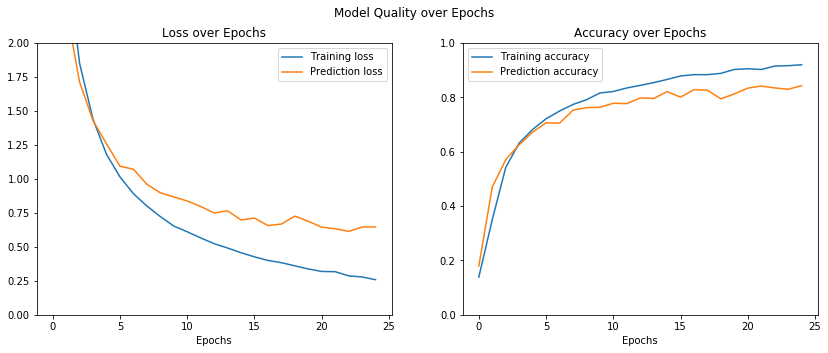

In [105]:
plot_history(model_1_training)

In [106]:
model_1.evaluate(X_test_reshaped_grey, y_test_coded, batch_size=16)

1421/1421 [==============================] - 0s 137us/step


[0.6468550786847888, 0.8430682619133103]

## Modell 2
baut auf dem ersten auf, hat aber mehrere Conv, batch und dropout layer. Es müssen bereits 65.000 Parameter trainiert werden. Die val_acc schwankt recht stark, hat zeitweise aber eine Testgenauigkeit von 90%.

In [0]:
model_2 = Sequential()

model_2.add(Conv2D(32, kernel_size=3, input_shape=(28, 28, 1), activation='relu', padding='same'))
model_2.add(BatchNormalization())

model_2.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model_2.add(BatchNormalization())

model_2.add(MaxPool2D(2))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model_2.add(BatchNormalization())

model_2.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model_2.add(BatchNormalization())

model_2.add(MaxPool2D(2))
model_2.add(Dropout(0.3))

model_2.add(Flatten())
model_2.add(Dense(62, activation='softmax'))

In [108]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_29 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_30 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 16)        4624      
__________

In [0]:
model_2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [0]:
model_2_training = model_2.fit(
    X_train_reshaped_grey,
    y_train_coded, 
    validation_data=(X_test_reshaped_grey, y_test_coded),
    epochs=25,
    batch_size=16,
    verbose=False
)

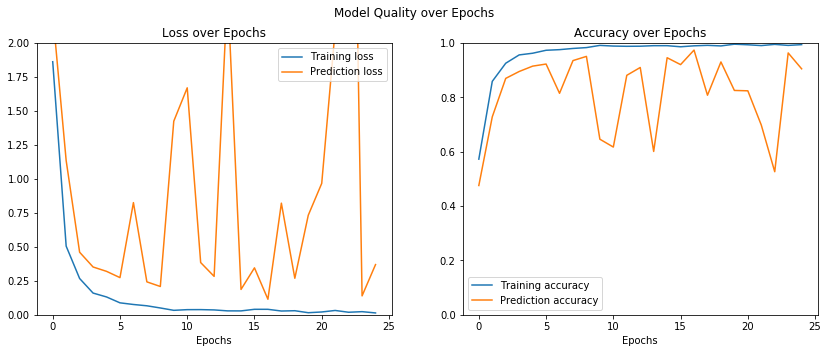

In [111]:
plot_history(model_2_training)

In [112]:
model_2.evaluate(X_test_reshaped_grey, y_test_coded, batch_size=16)

1421/1421 [==============================] - 0s 180us/step


[0.36947474506127215, 0.9049964813931067]

## Modell 3
hat insgesamt 6 conv, batch, pooling und 3 dropout layer. Um die Komplexität zu reduzieren endet es wie Modell 1 und Modell2 mit einem Flatten layer. Insgesamt müssen 360.000 Parameter traniert werden, was sich aber für eine 97% Testgenauigkeit lohnt. 

In [0]:
model_3 = Sequential()

model_3.add(Conv2D(32, kernel_size=3, input_shape=(28, 28, 1), activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(2))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(2))
model_3.add(Dropout(0.3))

model_3.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(2))
model_3.add(Dropout(0.4))

model_3.add(Flatten())
model_3.add(Dense(62, activation='softmax'))

In [115]:
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_33 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_34 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [0]:
model_3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [0]:
model_3_training = model_3.fit(
    X_train_reshaped_grey,
    y_train_coded, 
    validation_data=(X_test_reshaped_grey, y_test_coded),
    epochs=25,
    batch_size=16,
    verbose=False
)

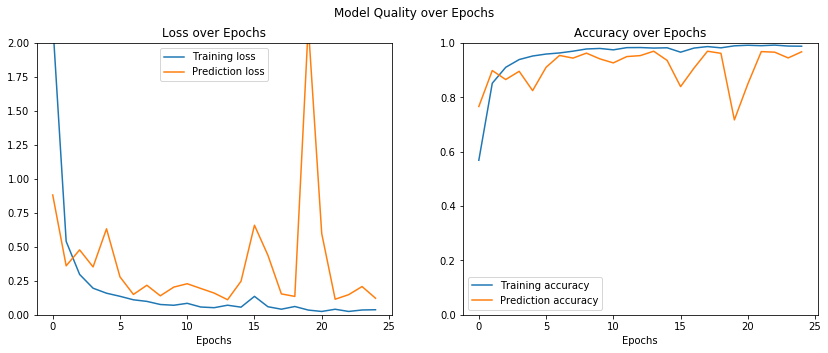

In [118]:
plot_history(model_3_training)

In [119]:
model_3.evaluate(X_test_reshaped_grey, y_test_coded, batch_size=16)

1421/1421 [==============================] - 0s 201us/step


[0.12202364577730986, 0.9676284306826178]

## Modell 4
hat verwendet wie Modell 5 und 6 nun die farbigen Bilder. Die Testgenauigkeit beträgt 89% und ist somit um 5% besser als das selbe Modell, das graue Bilder verwendet.

In [0]:
model_4 = Sequential()
model_4.add(Conv2D(5, kernel_size=3, activation='relu', input_shape=(28, 28, 3), padding='same', strides=2, dilation_rate=1))
model_4.add(MaxPool2D(2))
model_4.add(BatchNormalization())

model_4.add(Conv2D(15, kernel_size=3, activation='relu', input_shape=(28, 28, 3), padding='same', strides=1, dilation_rate=1))
model_4.add(MaxPool2D(2))
model_4.add(Flatten())
model_4.add(Dense(62, activation='softmax'))

In [121]:
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 14, 14, 5)         140       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 5)           0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 7, 7, 5)           20        
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 7, 7, 15)          690       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 3, 15)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 135)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 62)                8432      
Total para

In [0]:
model_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [0]:
model_4_training = model_4.fit(
    X_train_reshaped_color,
    y_train_coded, 
    validation_data=(X_test_reshaped_color, y_test_coded),
    epochs=25,
    batch_size=16,
    verbose=False
)

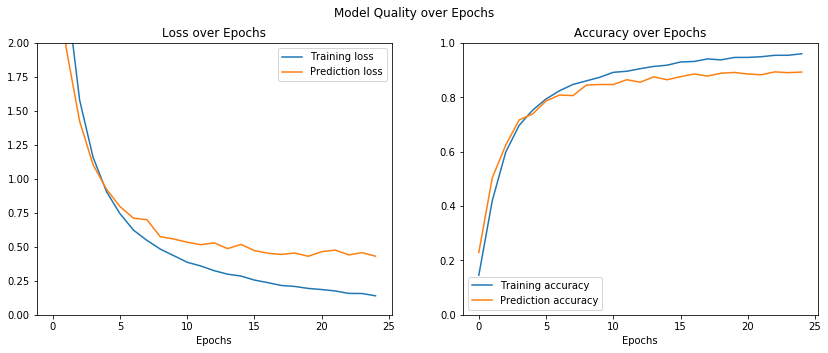

In [124]:
plot_history(model_4_training)

In [125]:
model_4.evaluate(X_test_reshaped_color, y_test_coded, batch_size=16)

1421/1421 [==============================] - 0s 150us/step


[0.43114721651315524, 0.8930330753829763]

## Modell 5
hat eine ca. 98% Testgenauigkeit und ist um 8% besser als Modell 2, hat jedoch eine höhere Komplexität.

In [0]:
model_5 = Sequential()

model_5.add(Conv2D(32, kernel_size=3, input_shape=(28, 28, 3), activation='relu', padding='same'))
model_5.add(BatchNormalization())

model_5.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model_5.add(BatchNormalization())

model_5.add(MaxPool2D(2))
model_5.add(Dropout(0.2))

model_5.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model_5.add(BatchNormalization())

model_5.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model_5.add(BatchNormalization())

model_5.add(MaxPool2D(2))
model_5.add(Dropout(0.3))

model_5.add(Flatten())
model_5.add(Dense(62, activation='softmax'))

In [127]:
model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
batch_normalization_40 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_41 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 16)        4624      
__________

In [0]:
model_5.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [0]:
model_5_training = model_5.fit(
    X_train_reshaped_color,
    y_train_coded, 
    validation_data=(X_test_reshaped_color, y_test_coded),
    epochs=25,
    batch_size=16,
    verbose=False
)

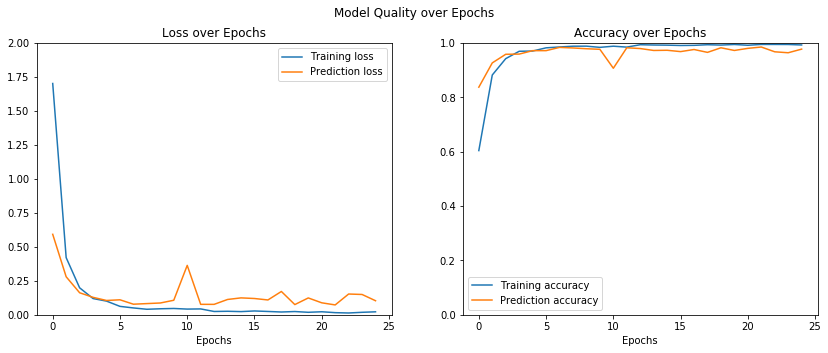

In [130]:
plot_history(model_5_training)

In [131]:
model_5.evaluate(X_test_reshaped_color, y_test_coded, batch_size=16)

1421/1421 [==============================] - 0s 183us/step


[0.10352611677667646, 0.9774806474313863]

## Modell 6
muss 360.000 Parameter trainieren, was ohne GPU sehr lange dauern kann. Die Trainingszeit wird aber mit einer 99% Testgenauigkeit belohnt.

In [0]:
model_6 = Sequential()

model_6.add(Conv2D(32, kernel_size=3, input_shape=(28, 28, 3), activation='relu', padding='same'))
model_6.add(BatchNormalization())
model_6.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model_6.add(BatchNormalization())
model_6.add(MaxPool2D(2))
model_6.add(Dropout(0.2))

model_6.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model_6.add(BatchNormalization())
model_6.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model_6.add(BatchNormalization())
model_6.add(MaxPool2D(2))
model_6.add(Dropout(0.3))

model_6.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model_6.add(BatchNormalization())
model_6.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model_6.add(BatchNormalization())
model_6.add(MaxPool2D(2))
model_6.add(Dropout(0.4))

model_6.add(Flatten())
model_6.add(Dense(62, activation='softmax'))

In [134]:
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
batch_normalization_44 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_45 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [0]:
model_6.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [0]:
model_6_training = model_6.fit(
    X_train_reshaped_color,
    y_train_coded, 
    validation_data=(X_test_reshaped_color, y_test_coded),
    epochs=25,
    batch_size=16,
    verbose=False
)

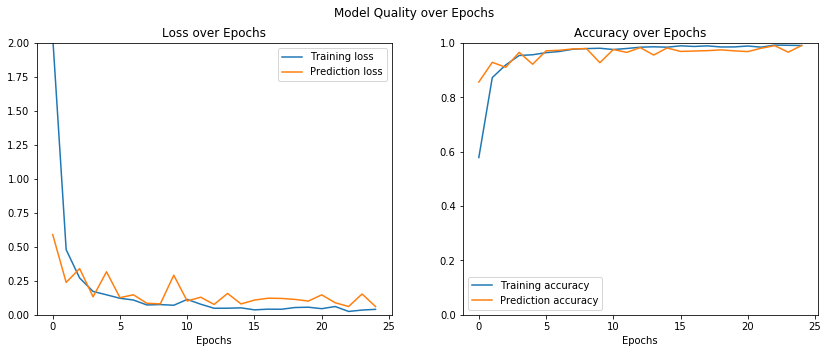

In [142]:
plot_history(model_6_training)

In [141]:
model_6.evaluate(X_test_reshaped_color, y_test_coded, batch_size=16)

1421/1421 [==============================] - 0s 214us/step


[0.06088188433289807, 0.9908515130190007]